In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
customers=pd.read_csv('/content/Customers.csv')
products=pd.read_csv('/content/Products.csv')
transactions=pd.read_csv('/content/Transactions.csv')

# Preprocessing

In [33]:
#merging customers and transactions
customer_transactions=pd.merge(transactions, customers[['CustomerID', 'Region']], on='CustomerID', how='left')
#total spend per customer and product
total_spent=customer_transactions.groupby('CustomerID')['TotalValue'].sum().reset_index()
total_spent=total_spent.rename(columns={'TotalValue': 'TotalSpend'})
#customer-product purchase matrix
customer_product_matrix=customer_transactions.groupby(['CustomerID', 'ProductID']).size().unstack(fill_value=0)
# Merging customer profile and product purchase matrix
customer_profile=pd.merge(customers[['CustomerID', 'Region']], total_spent, on='CustomerID', how='left')
customer_profile=pd.merge(customer_profile, customer_product_matrix, on='CustomerID', how='left')

# Feature Encoding and Normalization

In [34]:
#encoding region column
label_encoder=LabelEncoder()
customer_profile['Region']=label_encoder.fit_transform(customer_profile['Region'])
#checking missing values and handling them
if customer_profile.isnull().sum().any():
    customer_profile.fillna(0, inplace=True)
#normalize
scaler=StandardScaler()
profile_features=customer_profile.drop(columns=['CustomerID'])
normalized_features=scaler.fit_transform(profile_features)

# Computing Similarity bet Customers

In [35]:
cosine_sim = cosine_similarity(normalized_features)

# Lookalike

In [36]:
lookalike_results=defaultdict(list)
for i in range(20):
    sim_scores=list(enumerate(cosine_sim[i]))
    sim_scores=sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:4]
    for idx, score in sim_scores:
        lookalike_results[customers.iloc[i]['CustomerID']].append(
            {'CustomerID': customers.iloc[idx]['CustomerID'], 'SimilarityScore': score}
        )

# Saving the lookalike data csv file

In [37]:
lookalike_df=[]
for cust_id, lookalikes in lookalike_results.items():
    for lookalike in lookalikes:
        lookalike_df.append({'CustomerID': cust_id, 'RecommendedCustomerID': lookalike['CustomerID'], 'SimilarityScore': lookalike['SimilarityScore']})
lookalike_df=pd.DataFrame(lookalike_df)
lookalike_df.to_csv('Lookalike.csv', index=False)
print("Lookalike model saved as Lookalike.csv.")

Lookalike model saved as Lookalike.csv.


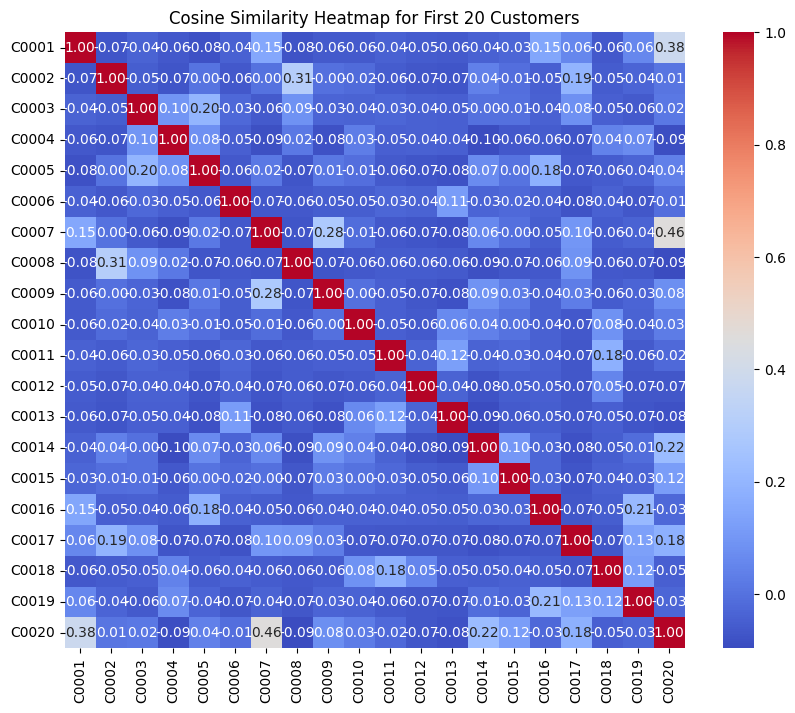

In [38]:
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim[:20, :20], annot=True, cmap='coolwarm', fmt='.2f', xticklabels=customers['CustomerID'][:20], yticklabels=customers['CustomerID'][:20])
plt.title('Cosine Similarity Heatmap for First 20 Customers')
plt.show()

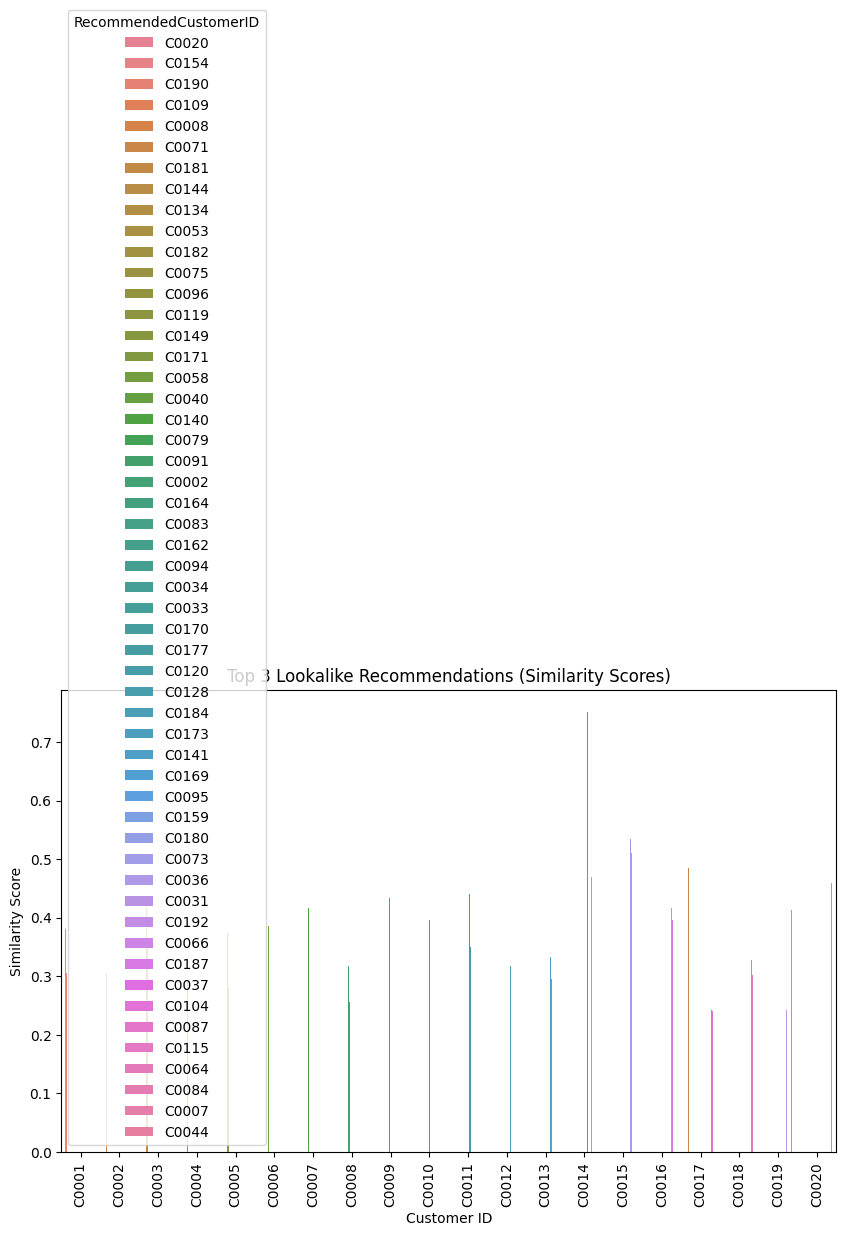

In [39]:
top_lookalikes=[]
for cust_id, lookalikes in lookalike_results.items():
    for lookalike in lookalikes:
        top_lookalikes.append({'CustomerID': cust_id, 'RecommendedCustomerID': lookalike['CustomerID'], 'SimilarityScore': lookalike['SimilarityScore']})
top_lookalikes_df=pd.DataFrame(top_lookalikes)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_lookalikes_df, x='CustomerID', y='SimilarityScore', hue='RecommendedCustomerID')
plt.xticks(rotation=90)
plt.title('Top 3 Lookalike Recommendations (Similarity Scores)')
plt.xlabel('Customer ID')
plt.ylabel('Similarity Score')
plt.show()

In [40]:
print("Top 3 Lookalikes for Each Customer:")
print(top_lookalikes_df)

Top 3 Lookalikes for Each Customer:
   CustomerID RecommendedCustomerID  SimilarityScore
0       C0001                 C0020         0.381084
1       C0001                 C0154         0.308014
2       C0001                 C0190         0.305656
3       C0002                 C0109         0.369291
4       C0002                 C0008         0.305720
5       C0002                 C0071         0.303526
6       C0003                 C0181         0.417741
7       C0003                 C0144         0.379586
8       C0003                 C0134         0.360701
9       C0004                 C0053         0.359758
10      C0004                 C0182         0.291747
11      C0004                 C0075         0.287292
12      C0005                 C0096         0.374153
13      C0005                 C0119         0.331498
14      C0005                 C0149         0.279554
15      C0006                 C0171         0.474710
16      C0006                 C0058         0.386434
17      C0